# Denver Crime Data

The city of Denver, CO publishes its crime data to their open data catalogue: [crime](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-crime).

I want to explore what the most often reported crimes are, what areas have the most crime (total, per capita, per area), trends in time of day, time of month, time of year. Explore outliers and if they are related to specific events. What is the probability that crime is increasing year over year? Can we predict where crimes will occur?

At minimum, plot time series incidents by area, by type, by year; analysis of most common crimes committed, levels of activity in each district in Denver; bayesian analysis of the probability that crime is increasing year-over-year; and model to predict likelihood of a crime taking place in a given area or at a given time during the day.

This dataset is a snapshot of the database as of 02/11/2019. Future updates will 

### About Crime Data
The Denver Police Department strives to make crime data as accurate as possible, but there is no avoiding the introduction of errors into this process, which relies on data furnished by many people and that cannot always be verified. Data on this site are updated Monday through Friday, adding new incidents and updating existing data with information gathered through the investigative process.

Not surprisingly, crime data become more accurate over time, as new incidents are reported and more information comes to light during investigations.

Crimes that occurred at least 30 days ago tend to be the most accurate, although records are returned for incidents that happened yesterday. This dynamic nature of crime data means that content provided here today will probably differ from content provided a week from now. Likewise, content provided on this site will probably differ somewhat from crime statistics published elsewhere by the City and County of Denver, even though they draw from the same database.

### Withheld Data
In accordance with legal restrictions against identifying sexual assault and child abuse victims and juvenile perpetrators, victims, and witnesses of certain crimes, this site includes the following precautionary measures: (a) Addresses of sexual assaults are not included. (b) Child abuse cases, and other crimes which by their nature involve juveniles, or which the reports indicate involve juveniles as victims, suspects, or witnesses, are not reported at all.

Crimes that are initially reported, but that are later determined not to have occurred, are called "unfounded" offenses. These incidents are excluded once they have been designated as unfounded.

### About Crime Locations
Crime locations reflect the approximate locations of crimes but are not mapped to actual property parcels. Certain crimes may not appear on maps if there is insufficient detail to establish a specific, mappable location.

## Importing Libraries and loading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from src.project_functions import compare_columns


In [2]:
figs_save = {}

In [71]:
f = open('results.txt', 'a')
print('Results\n ========= {} ======='.format(datetime.now()), file=f, end='\n'+'='*50+'\n'*3)

In [3]:
df_ = pd.read_csv('data/crime.csv')
df_.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


In [48]:
df_offense_codes = pd.read_csv('data/offense_codes.csv')
df_offense_codes.set_index(['OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION'], inplace=True)
df_offense_codes.sort_index(inplace=True)
df_offense_codes.head()

,,OFFENSE_TYPE_ID,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_ID,OFFENSE_CATEGORY_NAME,IS_CRIME,IS_TRAFFIC
OFFENSE_CODE,OFFENSE_CODE_EXTENSION,,,,,,
199,0,sovereign-treason-viol,Treason,all-other-crimes,All Other Crimes,1,0
399,0,immigration-violations,Immigration violation,all-other-crimes,All Other Crimes,1,0
902,0,homicide-family,Homicide by a family member,murder,Murder,1,0
903,0,hom-willful-kill-non-family-gu,Homicide by a stranger w/gun,murder,Murder,1,0
904,0,hom-willful-kill-nonfam-wp,Homicide by a stranger w/weapon,murder,Murder,1,0


### Changing all dates to python datetime object for easier manipulation

In [5]:
df_['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(df_['FIRST_OCCURRENCE_DATE'], infer_datetime_format=True)
df_['LAST_OCCURRENCE_DATE'] = pd.to_datetime(df_['LAST_OCCURRENCE_DATE'], infer_datetime_format=True)
df_['REPORTED_DATE'] = pd.to_datetime(df_['REPORTED_DATE'], infer_datetime_format=True)

In [6]:
df_.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,2016-06-15 23:31:00,NaT,2016-06-15 23:31:00,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,2017-10-11 12:30:00,2017-10-11 16:55:00,2018-01-29 17:53:00,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,2016-03-04 20:00:00,2016-04-25 08:00:00,2016-04-26 21:02:00,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,2018-01-30 19:20:00,NaT,2018-01-30 22:29:00,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,2017-06-22 20:53:00,NaT,2017-06-23 16:09:00,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


## Initial Explorations

### What are not crimes?

In [7]:
mask_not_crime = df_['IS_CRIME'] == 0
df_crime = df_[~mask_not_crime]
print('Crimes: {1}\t Not crimes: {0}'.format(df_[mask_not_crime].INCIDENT_ID.count(), df_crime.INCIDENT_ID.count()))

Crimes: 340193	 Not crimes: 119666


In [54]:
df_offense_codes.loc[(df_[mask_not_crime].OFFENSE_CODE.unique(), df_[mask_not_crime].OFFENSE_CODE_EXTENSION.unique()),:]

,,OFFENSE_TYPE_ID,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_ID,OFFENSE_CATEGORY_NAME,IS_CRIME,IS_TRAFFIC
OFFENSE_CODE,OFFENSE_CODE_EXTENSION,,,,,,
5401,0,traffic-accident-hit-and-run,Traffic accident - hit and run,traffic-accident,Traffic Accident,0,1
5420,0,traffic-accident-dui-duid,Traffic accident - DUI-DUID,traffic-accident,Traffic Accident,0,1
5441,0,traffic-accident,Traffic accident,traffic-accident,Traffic Accident,0,1


In [8]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459859 entries, 0 to 459858
Data columns (total 19 columns):
INCIDENT_ID               459859 non-null int64
OFFENSE_ID                459859 non-null int64
OFFENSE_CODE              459859 non-null int64
OFFENSE_CODE_EXTENSION    459859 non-null int64
OFFENSE_TYPE_ID           459859 non-null object
OFFENSE_CATEGORY_ID       459859 non-null object
FIRST_OCCURRENCE_DATE     459859 non-null datetime64[ns]
LAST_OCCURRENCE_DATE      145591 non-null datetime64[ns]
REPORTED_DATE             459859 non-null datetime64[ns]
INCIDENT_ADDRESS          414636 non-null object
GEO_X                     456120 non-null float64
GEO_Y                     456120 non-null float64
GEO_LON                   456120 non-null float64
GEO_LAT                   456120 non-null float64
DISTRICT_ID               459859 non-null int64
PRECINCT_ID               459859 non-null int64
NEIGHBORHOOD_ID           459859 non-null object
IS_CRIME                  459859 n

There are 19 columns. Last occurence date has the most null values (314268) possibly due to incomplete reporting or cases waiting to be updated or that the incident only happened once (we'll explore this a little further). Incident address has 45223 null values, of which some amount are sexual assaults since locations for these are not reported, and some may just not have a parcel address. There are 3739 null-valued GIS (GEO_X, GEO_Y, GEO_LON, GEO_LAT) entries which, again, should be inclusive of sexual assaults as their locations are not reported. All other coulmns are non-null for all entries.

### Length of time between first and last occurrence

In [9]:
df_has_last_occ = df_crime[~df_crime['LAST_OCCURRENCE_DATE'].isna()]
# df_has_last_occ['TIME_DELTA'] = df_has_last_occ['LAST_OCCURRENCE_DATE'] - df_has_last_occ['FIRST_OCCURRENCE_DATE']
df_has_last_occ = df_has_last_occ.assign(TIME_DELTA=
                                         df_has_last_occ['LAST_OCCURRENCE_DATE'] - df_has_last_occ['FIRST_OCCURRENCE_DATE'])

In [59]:
df_has_last_occ['TIME_DELTA'].describe()

count                     145210
mean      4 days 14:35:53.389298
std      34 days 04:48:40.249656
min            -1 days +04:00:00
25%              0 days 00:22:00
50%              0 days 06:00:00
75%              0 days 15:30:00
max           1609 days 23:00:00
Name: TIME_DELTA, dtype: object


In [ ]:
print(df_has_last_occ['TIME_DELTA'].describe(), file=f)

In [11]:
df_has_last_occ.loc[df_has_last_occ['TIME_DELTA'].idxmax()]

INCIDENT_ID                        2018669371
OFFENSE_ID                   2018669371110900
OFFENSE_CODE                             1109
OFFENSE_CODE_EXTENSION                      0
OFFENSE_TYPE_ID             sex-aslt-non-rape
OFFENSE_CATEGORY_ID            sexual-assault
FIRST_OCCURRENCE_DATE     2014-05-01 00:00:00
LAST_OCCURRENCE_DATE      2018-09-26 23:00:00
REPORTED_DATE             2018-09-29 14:27:00
INCIDENT_ADDRESS                          NaN
GEO_X                                     NaN
GEO_Y                                     NaN
GEO_LON                                   NaN
GEO_LAT                                   NaN
DISTRICT_ID                                 3
PRECINCT_ID                               311
NEIGHBORHOOD_ID                  country-club
IS_CRIME                                    1
IS_TRAFFIC                                  0
TIME_DELTA                 1609 days 23:00:00
Name: 454172, dtype: object

In [12]:
mask75 = df_has_last_occ['TIME_DELTA'] >= timedelta(hours=15, minutes=30)
df_has_last_occ[mask75]['TIME_DELTA'].describe()

count                      36453
mean     17 days 20:06:21.441856
std      66 days 12:36:54.211460
min              0 days 15:30:00
25%              1 days 00:00:00
50%              2 days 01:00:00
75%              7 days 00:00:00
max           1609 days 23:00:00
Name: TIME_DELTA, dtype: object

In [13]:
mask25 = df_has_last_occ['TIME_DELTA'] <= timedelta(minutes=21)
df_has_last_occ[mask25]['TIME_DELTA'].describe()

count                     36283
mean     0 days 00:06:14.137199
std      0 days 00:15:10.222343
min           -1 days +04:00:00
25%             0 days 00:00:00
50%             0 days 00:05:00
75%             0 days 00:10:00
max             0 days 00:21:00
Name: TIME_DELTA, dtype: object

In [14]:
maskNeg = df_has_last_occ['TIME_DELTA'] < timedelta(seconds=0)
df_has_last_occ[maskNeg]['TIME_DELTA'].describe()

count                          39
mean     -1 days +20:00:41.538461
std        0 days 05:43:32.424145
min             -1 days +04:00:00
25%             -1 days +18:45:00
50%             -1 days +23:00:00
75%             -1 days +23:45:00
max             -1 days +23:58:00
Name: TIME_DELTA, dtype: object

In [15]:
df_has_last_occ[maskNeg]

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,TIME_DELTA
46011,2014388104,2014388104570700,5707,0,criminal-trespassing,all-other-crimes,2014-07-26 11:19:00,2014-07-26 10:50:00,2014-07-26 11:19:00,NaN,3184906.0,1715230.0,-104.841967,39.795276,5,521,montbello,1,0,-1 days +23:31:00
46609,2014373704,2014373704299901,2999,1,criminal-mischief-mtr-veh,public-disorder,2014-07-19 05:00:00,2014-07-19 04:00:00,2014-07-19 05:27:00,4900 BLK N CLAYTON ST,3153498.0,1711590.0,-104.953815,39.785855,2,212,elyria-swansea,1,0,-1 days +23:00:00
52805,2014353737,2014353737299901,2999,1,criminal-mischief-mtr-veh,public-disorder,2014-07-09 03:45:00,2014-07-09 02:46:00,2014-07-09 11:09:00,NaN,3132226.0,1680712.0,-105.030073,39.701416,4,412,westwood,1,0,-1 days +23:01:00
56134,2014399282,2014399282240400,2404,0,theft-of-motor-vehicle,auto-theft,2014-08-01 08:22:00,2014-08-01 06:45:00,2014-08-01 08:22:00,800 BLOCK 25TH ST,3145450.0,1700140.0,-104.982683,39.754553,6,621,five-points,1,0,-1 days +22:23:00
64958,2014596887,2014596887131302,1313,2,assault-dv,other-crimes-against-persons,2014-11-08 22:45:00,2014-11-08 22:30:00,2014-11-08 22:49:00,10700 E DARTMOUTH AVE,3179718.0,1665260.0,-104.861679,39.658202,3,323,kennedy,1,0,-1 days +23:45:00
69989,20149515342,20149515342240400,2404,0,theft-of-motor-vehicle,auto-theft,2014-07-28 18:27:00,2014-07-28 07:00:00,2014-07-29 18:27:00,2300 BLOCK N NEWPORT ST,3166166.0,1699020.0,-104.909031,39.751131,2,222,north-park-hill,1,0,-1 days +12:33:00
102742,2015539465,2015539465240400,2404,0,theft-of-motor-vehicle,auto-theft,2015-09-17 12:46:00,2015-09-17 08:30:00,2015-09-17 13:56:00,1200 BLK N GALAPAGO ST,3141548.0,1693446.0,-104.996693,39.736237,1,123,lincoln-park,1,0,-1 days +19:44:00
113677,201594326,201594326239900,2399,0,theft-other,larceny,2015-02-16 17:55:00,2015-02-16 16:20:00,2015-02-17 17:50:00,2375 E 1ST AVE,3152768.0,1687025.0,-104.956935,39.718432,3,311,cherry-creek,1,0,-1 days +22:25:00
124400,2015752334,2015752334570700,5707,0,criminal-trespassing,all-other-crimes,2015-12-29 23:30:00,2015-12-29 03:30:00,2015-12-30 00:36:00,S LOWELL BLVD / W ADA PL,3130992.0,1680681.0,-105.034459,39.701349,4,412,westwood,1,0,-1 days +04:00:00
126545,2016151736,2016151736355000,3550,0,drug-poss-paraphernalia,drug-alcohol,2016-03-10 04:15:00,2016-03-10 03:50:00,2016-03-10 04:15:00,1700 BLOCK CALIFORNIA ST,3143321.0,1697211.0,-104.990313,39.746545,6,611,cbd,1,0,-1 days +23:35:00


### Missing locations and Sexual Assaults

In [16]:
df_no_loc = df_crime[df_crime['GEO_X'].isna()]
df_no_loc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3739 entries, 177 to 459566
Data columns (total 19 columns):
INCIDENT_ID               3739 non-null int64
OFFENSE_ID                3739 non-null int64
OFFENSE_CODE              3739 non-null int64
OFFENSE_CODE_EXTENSION    3739 non-null int64
OFFENSE_TYPE_ID           3739 non-null object
OFFENSE_CATEGORY_ID       3739 non-null object
FIRST_OCCURRENCE_DATE     3739 non-null datetime64[ns]
LAST_OCCURRENCE_DATE      2205 non-null datetime64[ns]
REPORTED_DATE             3739 non-null datetime64[ns]
INCIDENT_ADDRESS          0 non-null object
GEO_X                     0 non-null float64
GEO_Y                     0 non-null float64
GEO_LON                   0 non-null float64
GEO_LAT                   0 non-null float64
DISTRICT_ID               3739 non-null int64
PRECINCT_ID               3739 non-null int64
NEIGHBORHOOD_ID           3739 non-null object
IS_CRIME                  3739 non-null int64
IS_TRAFFIC                3739 non-nu

In [17]:
df_null_loc_codes = df_offense_codes[df_offense_codes['OFFENSE_CODE'].isin(df_no_loc['OFFENSE_CODE'].unique())]
df_null_loc_codes

,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_ID,OFFENSE_CATEGORY_NAME,IS_CRIME,IS_TRAFFIC
31,3601,1,sex-aslt-fondle-adult-victim,Fondling of an adult,sexual-assault,Sexual Assault,1,0
177,1102,0,sex-aslt-rape,Rape,sexual-assault,Sexual Assault,1,0
178,1102,1,sex-aslt-rape-pot,Rape by a person in a position of trust,sexual-assault,Sexual Assault,1,0
180,1109,0,sex-aslt-non-rape,Unlawful sexual contact,sexual-assault,Sexual Assault,1,0
181,1109,1,sex-aslt-non-rape-pot,Unlawful sexual contact,sexual-assault,Sexual Assault,1,0
188,1199,0,sex-aslt-w-object,Sexual assault with an object,sexual-assault,Sexual Assault,1,0
189,1199,1,sex-aslt-w-object-pot,Sexual assault w/object by a person in a posit...,sexual-assault,Sexual Assault,1,0


In [18]:
df_sex_codes = df_offense_codes[df_offense_codes['OFFENSE_TYPE_ID'].str.contains('sex')]
df_sex_codes

,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_ID,OFFENSE_CATEGORY_NAME,IS_CRIME,IS_TRAFFIC
31,3601,1,sex-aslt-fondle-adult-victim,Fondling of an adult,sexual-assault,Sexual Assault,1,0
33,3607,0,sex-off-incest-with-adult,Incest with an adult,other-crimes-against-persons,Other Crimes Against Persons,1,0
35,3612,0,sex-off-fail-to-register,Failure to register as a sex offender,all-other-crimes,All Other Crimes,1,0
36,3613,0,sex-off-registration-viol,Sex offender registration violation,all-other-crimes,All Other Crimes,1,0
38,3699,0,sex-off-other,Sex offense - other,other-crimes-against-persons,Other Crimes Against Persons,1,0
106,5309,3,harassment-sexual-in-nature,Harassment - sexual in nature,public-disorder,Public Disorder,1,0
166,1003,0,kidnap-minor-to-sex-aslt,Kidnap minor to sexually assault,all-other-crimes,All Other Crimes,1,0
167,1004,0,kidnap-adult-to-sex-aslt,Kidnap adult to sexually assault,all-other-crimes,All Other Crimes,1,0
176,1101,0,sex-aslt-gun,"Rape, perpetrator had a gun",sexual-assault,Sexual Assault,1,0
177,1102,0,sex-aslt-rape,Rape,sexual-assault,Sexual Assault,1,0


Not all sexual crime codes were contained within the null-valued location offenses. Are the codes not in this subset used in the database?

In [19]:
df_sex_notin = df_sex_codes[~df_sex_codes['OFFENSE_CODE'].isin(df_null_loc_codes['OFFENSE_CODE'])]

In [20]:
df_crime[df_crime['OFFENSE_CODE'].isin(df_sex_notin['OFFENSE_CODE'])].groupby('OFFENSE_CODE').count()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
OFFENSE_CODE,,,,,,,,,,,,,,,,,,
3612,1305,1305,1305,1305,1305,1305,316,1305,1296,1305,1305,1305,1305,1305,1305,1305,1305,1305
3613,82,82,82,82,82,82,3,82,82,82,82,82,82,82,82,82,82,82
5309,1854,1854,1854,1854,1854,1854,982,1854,1294,1854,1854,1854,1854,1854,1854,1854,1854,1854


In [21]:
mask_sex_loc = df_crime[df_crime['OFFENSE_CODE'].isin(df_sex_notin['OFFENSE_CODE'])].groupby('OFFENSE_CODE')['OFFENSE_CODE'].unique()
df_offense_codes[df_offense_codes['OFFENSE_CODE'].isin(mask_sex_loc)]

,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_ID,OFFENSE_CATEGORY_NAME,IS_CRIME,IS_TRAFFIC
35,3612,0,sex-off-fail-to-register,Failure to register as a sex offender,all-other-crimes,All Other Crimes,1,0
36,3613,0,sex-off-registration-viol,Sex offender registration violation,all-other-crimes,All Other Crimes,1,0
103,5309,0,harassment,Harassment,public-disorder,Public Disorder,1,0
104,5309,1,harassment-dv,Harassment - DV,public-disorder,Public Disorder,1,0
105,5309,2,harassment-obscene,Obscene harassment,public-disorder,Public Disorder,1,0
106,5309,3,harassment-sexual-in-nature,Harassment - sexual in nature,public-disorder,Public Disorder,1,0


No sexual assaults have locations included. However, locations for sexual harassment and sex offenders failing to register are present in the database.

## What crimes are most frequent?

### How many different types of crimes are represented here?

In [22]:
len(df_crime['OFFENSE_TYPE_ID'].unique())

195

### Crime totals by category

In [23]:
df_crime.groupby('OFFENSE_CATEGORY_ID')['OFFENSE_CATEGORY_ID'].count()

OFFENSE_CATEGORY_ID
aggravated-assault              10731
all-other-crimes                84195
arson                             576
auto-theft                      24159
burglary                        22900
drug-alcohol                    30678
larceny                         46174
murder                            261
other-crimes-against-persons    22363
public-disorder                 48290
robbery                          5957
sexual-assault                   3739
theft-from-motor-vehicle        34010
white-collar-crime               6160
Name: OFFENSE_CATEGORY_ID, dtype: int64

/home/mosqueteiro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


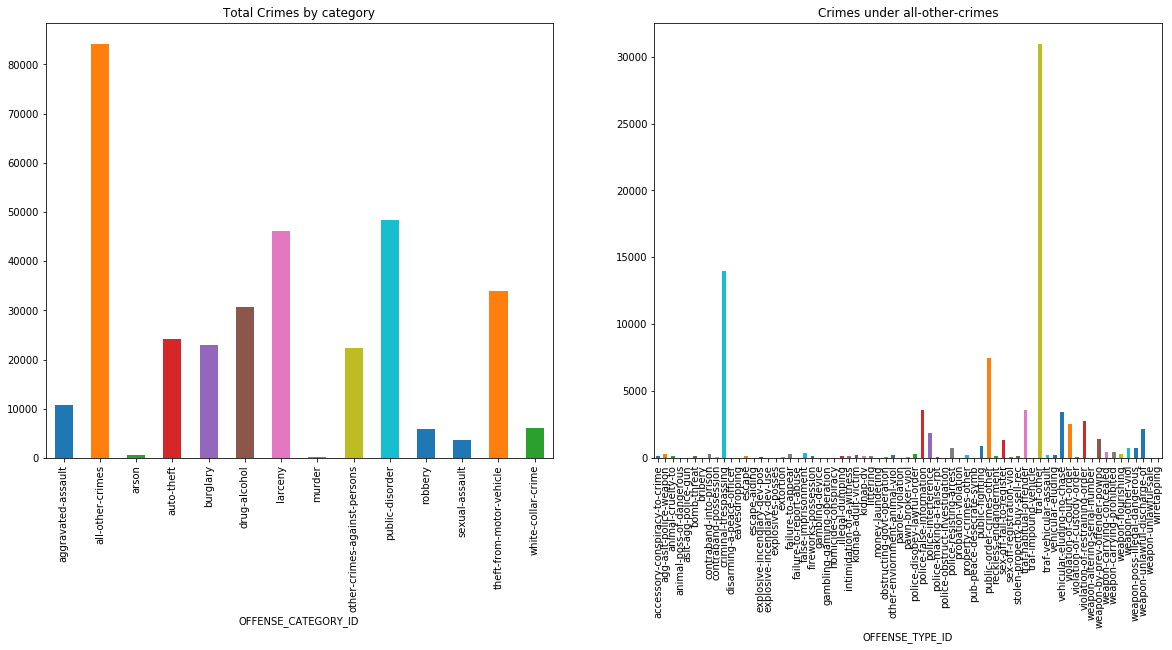

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

df_category = df_crime[~mask_not_crime].groupby('OFFENSE_CATEGORY_ID')
df_category['OFFENSE_CATEGORY_ID'].count().plot(kind='bar', ax=ax1)
ax1.set_title('Total Crimes by category')

df_crime[df_crime['OFFENSE_CATEGORY_ID'] == 'all-other-crimes'
        ].groupby('OFFENSE_TYPE_ID')['OFFENSE_TYPE_ID'].count().plot(kind='bar', ax=ax2)
ax2.set_title('Crimes under all-other-crimes')

figs_save['Total crimes by category'] = (fig, 'tot_crime_categ.jpg')

In [72]:
print(df_crime[df_crime['OFFENSE_CATEGORY_ID'] == 'all-other-crimes'].groupby('OFFENSE_TYPE_ID')['OFFENSE_TYPE_ID']
      .count(), file=f)
df_crime[df_crime['OFFENSE_CATEGORY_ID'] == 'all-other-crimes'].groupby('OFFENSE_TYPE_ID')['OFFENSE_TYPE_ID'].count()

OFFENSE_TYPE_ID
accessory-conspiracy-to-crime       136
agg-aslt-police-weapon              293
animal-cruelty-to                   125
animal-poss-of-dangerous             14
aslt-agg-police-gun                   7
bomb-threat                         159
bribery                              20
contraband-into-prison              273
contraband-possession                55
criminal-trespassing              13989
disarming-a-peace-officer            27
eavesdropping                         2
escape                              135
escape-aiding                         4
explosive-incendiary-dev-pos         33
explosive-incendiary-dev-use         14
explosives-posses                     1
extortion                            92
failure-to-appear                   308
failure-to-report-abuse               3
false-imprisonment                  365
fireworks-possession                158
gambling-device                       4
gambling-gaming-operation            10
homicide-conspiracy     

### By district

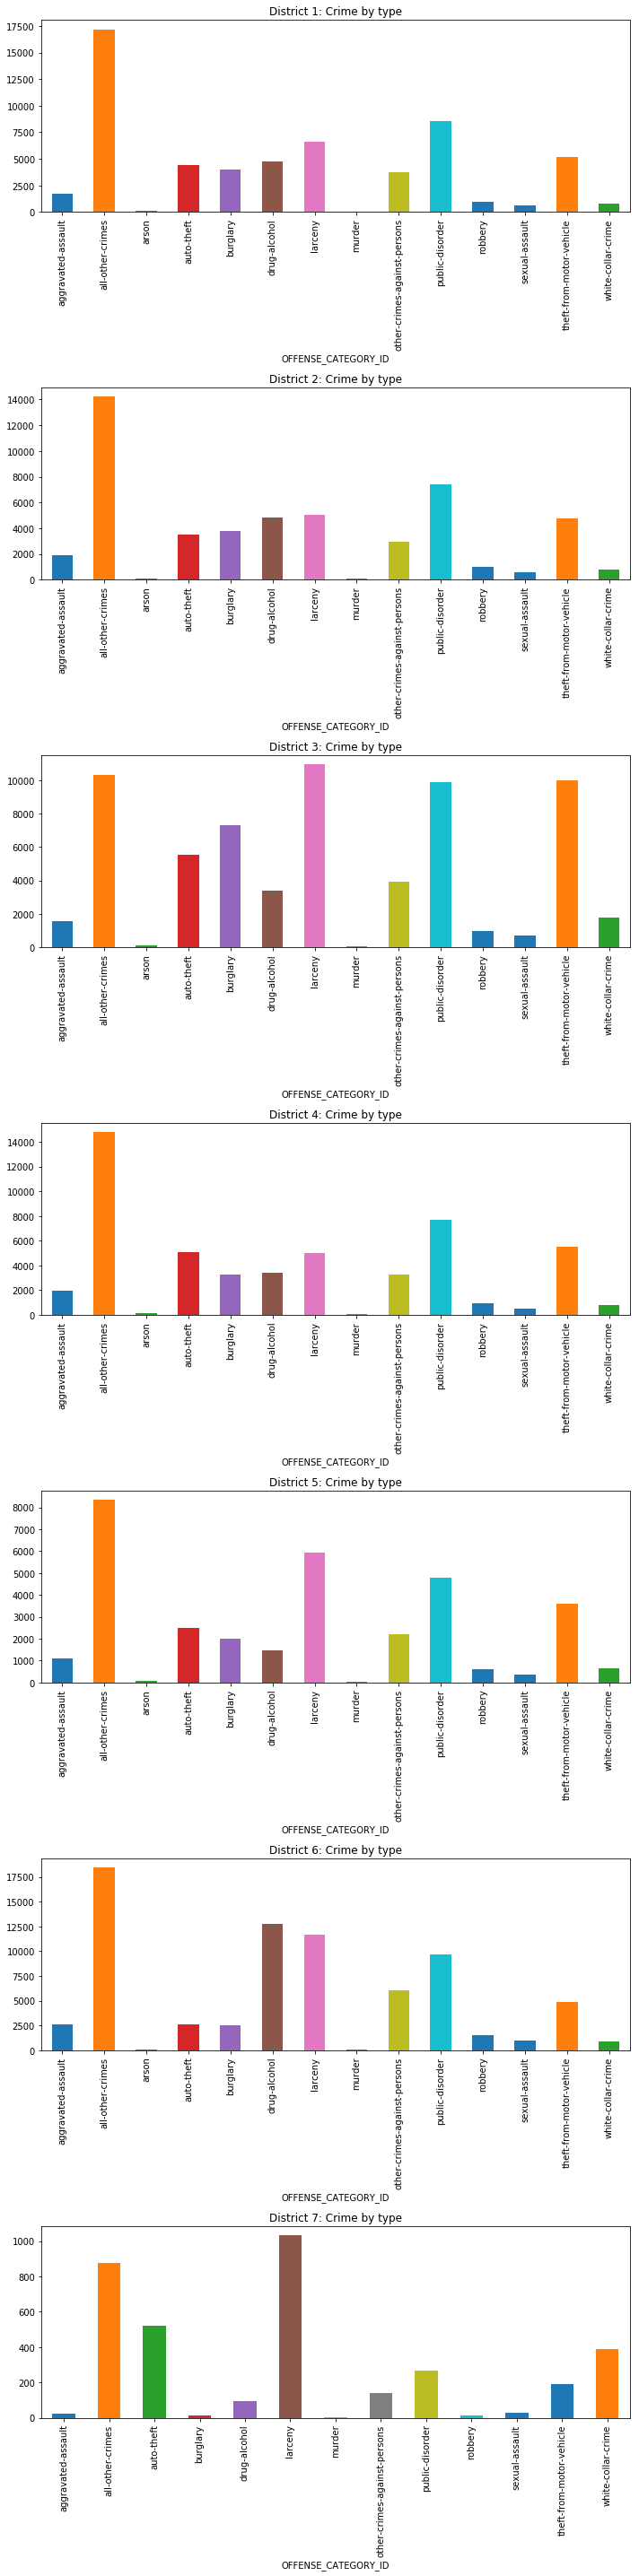

In [26]:
districts = sorted(df_crime['DISTRICT_ID'].unique())
# df_districts = df_crime.groupby(['OFFENSE_CATEGORY_ID', 'DISTRICT_ID'])

# df_districts['DISTRICT_ID'].count().plot(kind='bar', subplots=True)
# df_category[df_category['DISTRICT_ID'] == 1].head()
# df_districts.columns
# df_category[df_category['DISTRICT_ID'] == 1]['OFFENSE_CATEGORY_ID'].count().plot(kind='bar')

fig, axes = plt.subplots(len(districts),1, figsize=(10,40))

for district in districts:
    df_crime[df_crime['DISTRICT_ID'] == district
            ].groupby('OFFENSE_CATEGORY_ID')['OFFENSE_CATEGORY_ID'].count().plot(kind='bar', ax=axes[district-1])
    axes[district-1].set_title(f'District {district}: Crime by type')
fig.tight_layout()

figs_save['District crime by type'] = (fig, 'dist_crime_by_type.jpg')

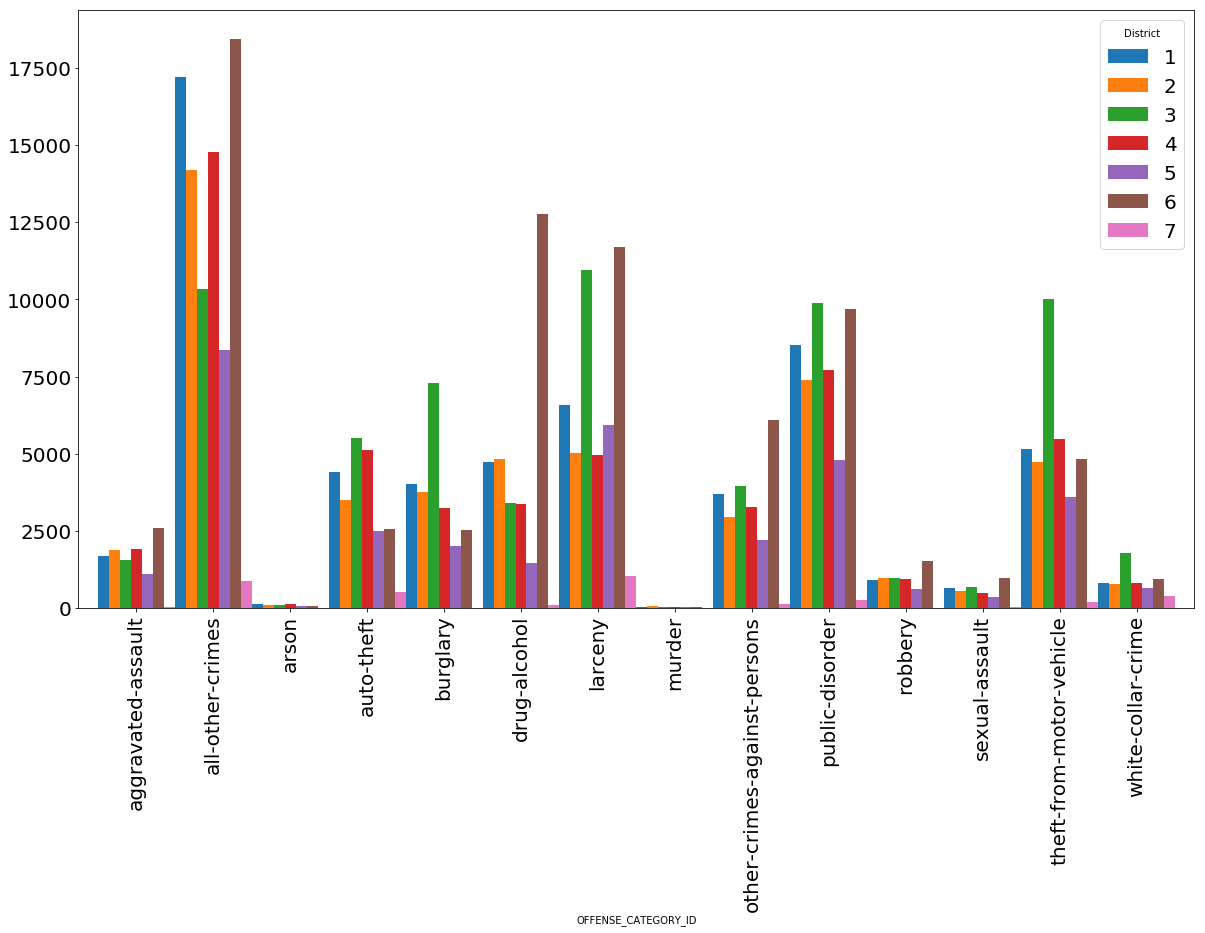

In [27]:
fig1, ax = plt.subplots(figsize=(20,11))

df_crime.groupby('OFFENSE_CATEGORY_ID').DISTRICT_ID.value_counts().sort_index().unstack().plot(kind='bar',  
                                                                                               ax=ax,
                                                                                               fontsize=20,
                                                                                               width=1
                                                                                              )
ax.legend(title='District', fontsize=20)

figs_save['Crime by category and district'] = (fig1, 'crime_categ_dist.jpg')

The breakdown of the crime counts by category type and district shows some interesting trends to investigate further...

## Time series

In [28]:
oldest_date = df_crime['FIRST_OCCURRENCE_DATE'].min()
newest_date = df_crime['FIRST_OCCURRENCE_DATE'].max()
newest_date

Timestamp('2019-02-11 07:35:00')

In [29]:
# mask2019 = df_crime['FIRST_OCCURRENCE_DATE'] > datetime(year=2018, month=12, day=31, hour=23, minute=59, second=59)
mask2019 = df_crime.FIRST_OCCURRENCE_DATE.dt.year == 2019
df_crime[~mask2019].FIRST_OCCURRENCE_DATE.max()

Timestamp('2018-12-31 23:59:00')

In [30]:
df_crime[~mask2019].groupby([df_crime.FIRST_OCCURRENCE_DATE.dt.year, 
                             df_crime.FIRST_OCCURRENCE_DATE.dt.month])['INCIDENT_ID'].count()
# df_crime[~mask2019].groupby(df_crime.FIRST_OCCURRENCE_DATE.dt.year
#                            ).FIRST_OCCURRENCE_DATE.dt.month.value_counts()

FIRST_OCCURRENCE_DATE  FIRST_OCCURRENCE_DATE
2014                   1                        4271
                       2                        4222
                       3                        5193
                       4                        5029
                       5                        5440
                       6                        5450
                       7                        5709
                       8                        5936
                       9                        5684
                       10                       5635
                       11                       4655
                       12                       4762
2015                   1                        5352
                       2                        4337
                       3                        5331
                       4                        5614
                       5                        5646
                       6                        5717
 

### Yearly crime

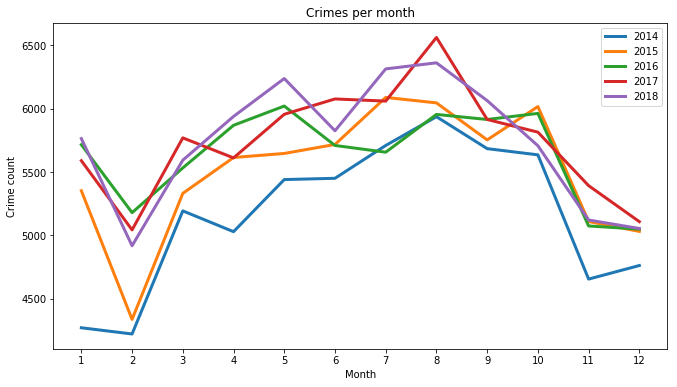

In [31]:
fig, ax = plt.subplots(figsize=(11,6))
title = 'Crimes per month'

df_year_month = df_crime[~mask2019].groupby([df_crime.FIRST_OCCURRENCE_DATE.dt.year, 
                                             df_crime.FIRST_OCCURRENCE_DATE.dt.month]
                                           ).INCIDENT_ID.count().unstack(0)
df_year_month.rename_axis('Year', axis='columns',inplace=True)
df_year_month.index.rename('Month', inplace=True)

df_year_month.plot(xticks=range(1,13), ax=ax, linewidth=3)

ax.set_title(title)
ax.set_xlabel('Month')
ax.set_ylabel('Crime count')
ax.legend(loc='upper right')

figs_save[title] = (fig, 'crime_year.jpg')

### Frequentists Hypothesis testing
$H_0: \mu_{year_i} = \mu_{year_j}, ~where ~year \in \{ 2014, 2015, 2016, 2017, 2018 \} \\
H_a: \mu_{year_i} \ne \mu_{year_j} $



#### Average crime per month

In [32]:
df_year_month.describe()

Year,2014,2015,2016,2017,2018
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,5165.500000,5503.250000,5636.000000,5740.916667,5741.083333
std,577.436262,507.237102,353.940416,428.240047,492.155825
min,4222.000000,4337.000000,5049.000000,5043.000000,4918.000000
25%,4735.250000,5275.500000,5443.750000,5539.750000,5475.000000
50%,5316.500000,5630.000000,5712.000000,5791.500000,5794.000000
75%,5647.250000,5818.750000,5924.000000,5981.000000,6106.500000
max,5936.000000,6088.000000,6020.000000,6561.000000,6361.000000


In [74]:
month_change = compare_columns(df_year_month, alpha=0.05)
print('-= Monthly Comparison =-', file=f)
print(month_change, file=f)
month_change

,test,t,p,Reject_Null
0,2014/2015,-4.155984,0.001600,True
1,2014/2016,-3.834113,0.002775,True
2,2014/2017,-6.525253,0.000043,True
3,2014/2018,-5.410776,0.000213,True
4,2015/2016,-1.454593,0.173715,False
5,2015/2017,-3.234155,0.007956,False
6,2015/2018,-3.254343,0.007676,False
7,2016/2017,-1.330509,0.210274,False
8,2016/2018,-1.449411,0.175127,False
9,2017/2018,-0.002604,0.997969,False


#### Average crime per day of year

In [33]:
df_year_day = df_crime[~mask2019].groupby([df_crime.FIRST_OCCURRENCE_DATE.dt.year, 
                                           df_crime.FIRST_OCCURRENCE_DATE.dt.dayofyear]
                                         ).INCIDENT_ID.count().unstack(0)
df_year_day.rename_axis('Year', axis=1, inplace=True)
df_year_day.index.rename('DayOfYear', inplace=True)
df_year_day.describe()

Year,2014,2015,2016,2017,2018
count,364.000000,365.000000,366.000000,365.000000,365.000000
mean,170.291209,180.928767,184.786885,188.742466,188.747945
std,27.354379,26.261792,24.450754,24.164602,25.279145
min,60.000000,75.000000,78.000000,80.000000,78.000000
25%,154.000000,167.000000,172.000000,175.000000,174.000000
50%,172.500000,182.000000,186.000000,189.000000,190.000000
75%,189.000000,198.000000,200.000000,203.000000,205.000000
max,255.000000,249.000000,242.000000,259.000000,255.000000


In [75]:
doy_change = compare_columns(df_year_day, alpha=0.05)
print('-= Daily Comparison =-', file=f)
print(doy_change, file=f)
doy_change

,test,t,p,Reject_Null
0,2014/2015,-6.509310,2.512989e-10,True
1,2014/2016,-7.991797,1.787661e-14,True
2,2014/2017,-11.929251,6.631717e-28,True
3,2014/2018,-11.494441,2.742216e-26,True
4,2015/2016,-2.211489,2.762280e-02,False
5,2015/2017,-4.943683,1.172278e-06,True
6,2015/2018,-4.719697,3.374303e-06,True
7,2016/2017,-2.365203,1.854391e-02,False
8,2016/2018,-2.229666,2.637907e-02,False
9,2017/2018,-0.003659,9.970827e-01,False


#### Monthly proportion of crimes in a year

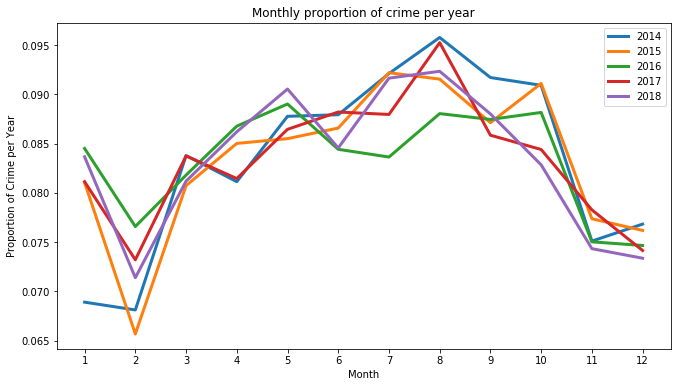

In [36]:
fig, ax = plt.subplots(figsize=(11,6))
title = 'Monthly proportion of crime per year'

month_prop = df_year_month / df_year_month.sum()
month_prop.plot(xticks=range(1,13), ax=ax, linewidth=3)

ax.set_title(title)
ax.set_xlabel('Month')
ax.set_ylabel('Proportion of Crime per Year')
ax.legend(loc='upper right')

figs_save[title] = (fig, 'crime_month_prop.jpg')

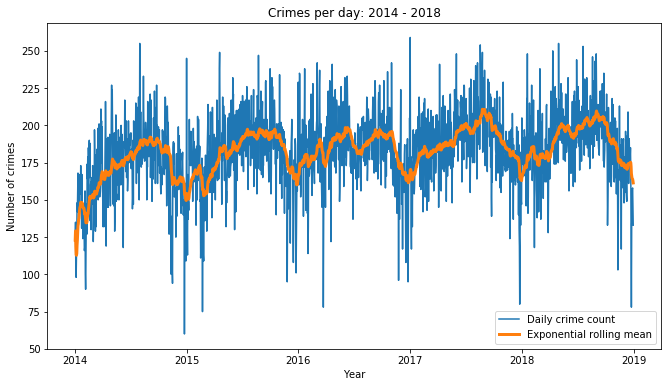

In [37]:
fig, ax = plt.subplots(figsize=(11,6))
title = 'Crimes per day: 2014 - 2018'

date_counts = df_crime[~mask2019].FIRST_OCCURRENCE_DATE.dt.date.value_counts().sort_index()
date_counts.plot(ax=ax, label='Daily crime count')
date_counts.ewm(alpha=0.05).mean().plot(ax=ax, label='Exponential rolling mean', linewidth=3)

ax.legend(loc='lower right')
ax.set_xlabel('Year')
ax.set_ylabel('Number of crimes')
ax.set_title(title)

figs_save[title] = (fig, 'crime_daily_alltime.jpg')

### Daliy Crime

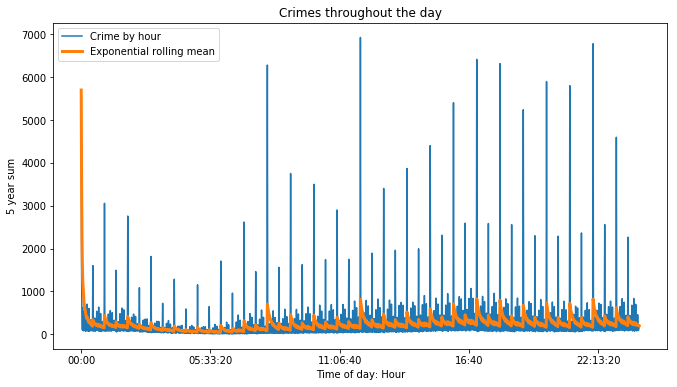

In [77]:
fig, ax = plt.subplots(figsize=(11,6))
title = 'Crimes throughout the day'

time_counts = df_crime[~mask2019].FIRST_OCCURRENCE_DATE.dt.time.value_counts().sort_index()
time_counts.plot(ax=ax, label='Crime by hour')
time_counts.ewm(alpha=0.1).mean().plot(ax=ax, 
                                       label='Exponential rolling mean', 
                                       linewidth=3, 
#                                        xticks=range(0,24,2)
                                      )

ax.set_xlabel('Time of day: Hour')
ax.set_ylabel('5 year sum')
ax.set_title(title)
ax.legend()

figs_save[title] = (fig, 'time_artifacts.png')

Spikes at regular repeating intervals when  suggests an artifact of how the data is recorded. Some of the recordings are rounded to the nearst hour, half hour, etc. Counting by hour removes these spikes.

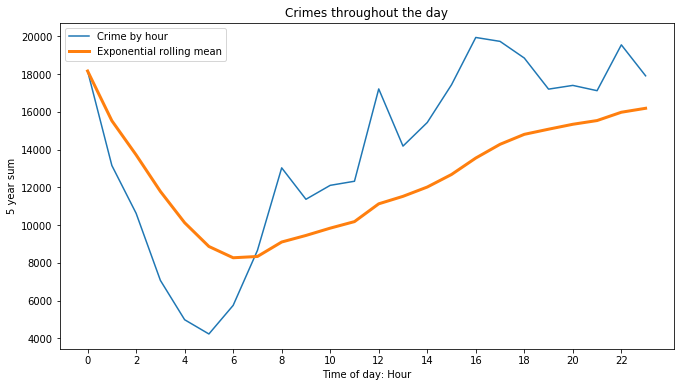

In [39]:
fig, ax = plt.subplots(figsize=(11,6))
title = 'Crimes throughout the day'

time_counts = df_crime[~mask2019].FIRST_OCCURRENCE_DATE.dt.hour.value_counts().sort_index()
time_counts.plot(ax=ax, label='Crime by hour')
time_counts.ewm(alpha=0.1).mean().plot(ax=ax, 
                                       label='Exponential rolling mean', 
                                       linewidth=3, 
                                       xticks=range(0,24,2)
                                      )

ax.set_xlabel('Time of day: Hour')
ax.set_ylabel('5 year sum')
ax.set_title(title)
ax.legend()

figs_save[title] = (fig, 'crime_time_day.jpg')

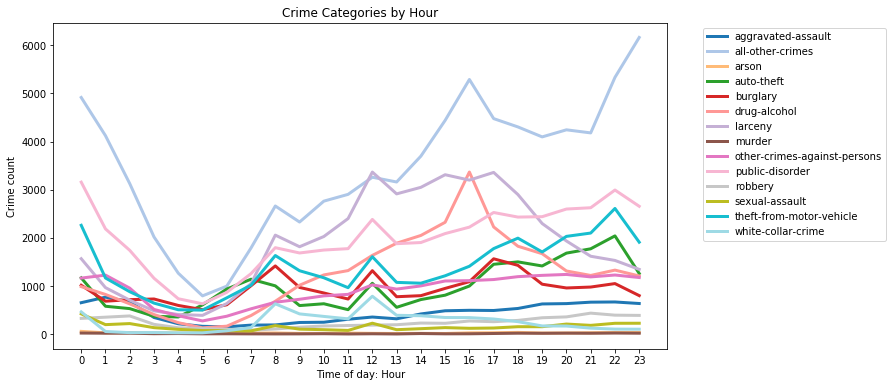

In [40]:
fig, ax = plt.subplots(figsize=(11,6))
title = 'Crime Categories by Hour'

time_cat_count = df_crime[~mask2019
                         ].groupby(['OFFENSE_CATEGORY_ID', 
                                    df_crime[~mask2019].FIRST_OCCURRENCE_DATE.dt.hour]
                                  ).INCIDENT_ID.count().unstack(0)
time_cat_count.index.rename('Hour', inplace=True)

time_cat_count.plot(ax=ax, 
                    cmap='tab20',
                    title=title,
                    linewidth=3,
                    xticks=range(24)
                   )

# time_cat_count.ewm(alpha=0.7).mean().unstack(0).plot(ax=ax, 
#                                                      cmap='tab20',
#                                                      title=title,
#                                                      linewidth=3,
#                                                      xticks=range(24)
#                                                     )
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlabel('Time of day: Hour')
ax.set_ylabel('Crime count')
# ax.set_title(title)

figs_save[title] = (fig, 'crime_cate_hour.jpg')
# time_cat_count.ewm(alpha=0.5).mean().unstack(0).head(35)
# time_cat_count.plot(ax=ax)

In [41]:
time_cat_count.describe()

OFFENSE_CATEGORY_ID,aggravated-assault,all-other-crimes,arson,auto-theft,burglary,drug-alcohol,larceny,murder,other-crimes-against-persons,public-disorder,robbery,sexual-assault,theft-from-motor-vehicle,white-collar-crime
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,435.166667,3430.250000,23.750000,985.958333,940.125000,1252.166667,1888.000000,10.750000,914.666667,1977.833333,243.125000,153.125000,1386.791667,251.666667
std,197.589532,1426.920041,9.865398,471.549202,275.701526,786.889787,1011.782027,6.647981,312.484110,683.857198,107.193572,78.332243,575.461099,201.575461
min,151.000000,794.000000,12.000000,355.000000,507.000000,130.000000,389.000000,2.000000,273.000000,629.000000,80.000000,66.000000,498.000000,26.000000
25%,244.750000,2577.750000,15.000000,588.500000,728.750000,668.500000,1027.250000,5.000000,707.500000,1726.250000,161.750000,96.250000,1003.000000,93.000000
50%,451.000000,3478.000000,23.000000,967.000000,953.500000,1223.500000,1874.500000,9.500000,1011.500000,1995.000000,226.500000,133.500000,1263.500000,213.500000
75%,633.500000,4338.000000,28.000000,1298.000000,1039.250000,1708.750000,2902.500000,18.000000,1178.250000,2460.750000,342.000000,199.000000,1809.250000,370.500000
max,767.000000,6163.000000,56.000000,2040.000000,1564.000000,3367.000000,3366.000000,21.000000,1239.000000,3157.000000,435.000000,420.000000,2610.000000,786.000000


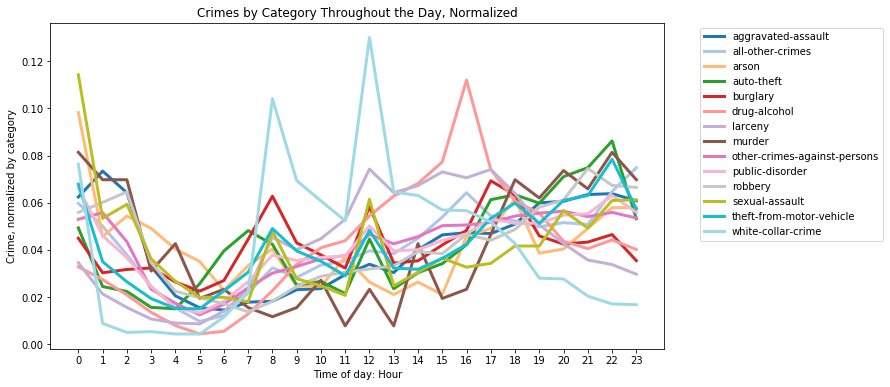

In [42]:
fig, ax = plt.subplots(figsize=(11,6))
title = 'Crimes by Category Throughout the Day, Normalized'

time_cat_prop = time_cat_count / time_cat_count.sum()
time_cat_prop.plot(ax=ax,
                   cmap='tab20',
                   title=title,
                   linewidth=3,
                   xticks=range(24)
                  )

ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlabel('Time of day: Hour')
ax.set_ylabel('Crime, normalized by category')

figs_save[title] = (fig, 'crime_cate_hour_norm.jpg')

## Save all specified figures

In [78]:
f

<_io.TextIOWrapper name='results.txt' mode='a' encoding='UTF-8'>

In [43]:
for fig, name in figs_save.values():
    fig.savefig('images/'+name)

In [76]:
f.close()

In [69]:
for fig, name in figs_save.values():
    print('[]: images/',name, sep='')

[]: images/tot_crime_categ.jpg
[]: images/dist_crime_by_type.jpg
[]: images/crime_categ_dist.jpg
[]: images/crime_year.jpg
[]: images/crime_month_prop.jpg
[]: images/crime_daily_alltime.jpg
[]: images/crime_time_day.jpg
[]: images/crime_cate_hour.jpg
[]: images/crime_cate_hour_norm.jpg
